# 

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import joblib
import matplotlib.pyplot as plt
import sys
sys.path.append('./src')

from src.data import load_data_part1, CustomAnalyzer
from src.eval import print_score
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

In [3]:
X, y = load_data_part1()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

svm_clf = LinearSVC(random_state=0, tol=1e-5, max_iter=20000, class_weight='balanced')
svm_clf.fit(X_train, y_train)

y_hat = svm_clf.predict(X_test)

100%|██████████| 14354/14354 [00:00<00:00, 47204.27it/s]


In [4]:
d = joblib.load("./part1_speaker_recognition/gridsearch/results/part1_hrscv_LogisticRegression.pkl")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
pipeline = d.best_estimator_
pipeline.fit(X_train, y_train)
print(y_train)
y_hat = pipeline.predict(X_test)

/home/charles/.local/lib/python3.11/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/charles/.local/lib/python3.11/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/charles/.local/lib/python3.11/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid 

[1 1 1 ... 1 1 1]


100%|██████████| 14354/14354 [00:00<00:00, 17237.34it/s]


In [67]:
def countValue(l):
    d = {-1:0, 1:0}
    for v in l:
        # d[v] = d.get(v, 0) + 1
        d[v] += 1
    return d

def windows_post(y, size=1, threshold=2):
    """
    Convolue sur la liste et regarde le nombre de voisin dans la fenêtre centré sur le point. 

    * Même nombre de valeur des deux cotés = frontière = ne pas changer la valeur
    * 
    """
    new_y = y.copy()
    for i in range(size, len(y) - size):
        window = y[i - size : i + size + 1]
        d = countValue(window)
        if d[-1] < d[1]:
            new_y[i] = 1
        elif d[-1] > d[1]:
            new_y[i] = -1
        else:
            pass
    return new_y

one_windows_y_hat = windows_post(y_hat)

two_windows_y_hat = windows_post(y_hat, size=2)

three_windows_y_hat = windows_post(y_hat, size=3)

four_windows_y_hat = windows_post(y_hat, size=4)

one_two_windows_y_hat = windows_post(one_windows_y_hat, size=2)

df = pd.DataFrame({
    "True Label": y_test,
    "Prediction": y_hat,
    # "Size=1": one_windows_y_hat,
    # "Size=2": two_windows_y_hat,
    # "Size=3": three_windows_y_hat,
    # "Size=4": four_windows_y_hat,
    # "size=1 then 2": one_two_windows_y_hat
})

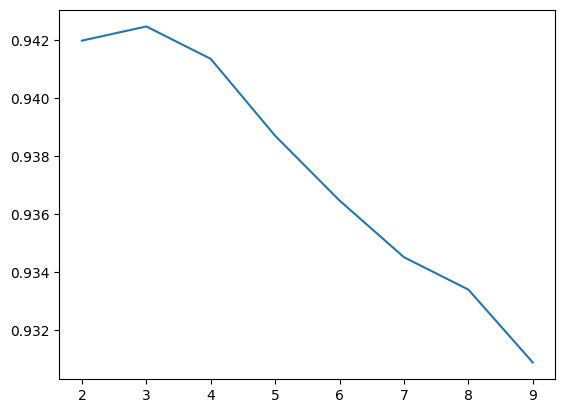

In [27]:
tmp = windows_post(y_hat)
lx, ly = [], []
for i in range(2, 10):
    tmp = windows_post(tmp, size=i)
    f1 = f1_score(y_test, tmp, average="micro")
    lx.append(i)
    ly.append(f1)
plt.plot(lx, ly)


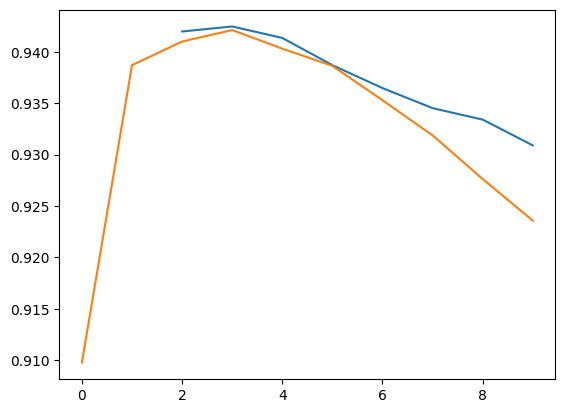

In [28]:
lx2, ly2 = [], []
for i in range(0, 10):
    tmp = windows_post(y_hat, size=i)
    f1 = f1_score(y_test, tmp, average="micro")
    lx2.append(i)
    ly2.append(f1)
plt.plot(lx, ly)
plt.plot(lx2, ly2)

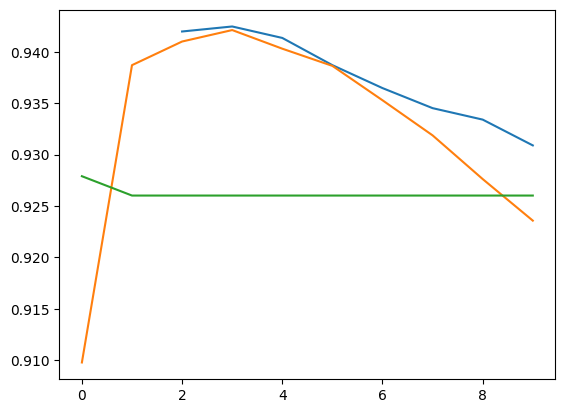

In [72]:
tmp = windows_post(y_hat, size=2)
lx3, ly3 = [], []
for i in range(0, 10):
    tmp = windows_post(tmp, size=9)
    f1 = f1_score(y_test, tmp, average="micro")
    lx3.append(i)
    ly3.append(f1)
plt.plot(lx, ly)
plt.plot(lx2, ly2)
plt.plot(lx3, ly3)


    Best résult w/ postprocessing on test :
    =====
    Macro F1-score : 0.7998576634043362
    Micro F1-score : 0.9424550647903024
    Macro ROC-AUC: 0.7340885846169805
    Weighted ROC-AUC: 0.7340885846169805
    Classification report :
                  precision    recall  f1-score   support

          -1       0.96      0.47      0.63      1500
           1       0.94      1.00      0.97     12854

    accuracy                           0.94     14354
   macro avg       0.95      0.73      0.80     14354
weighted avg       0.94      0.94      0.93     14354

    =====
    


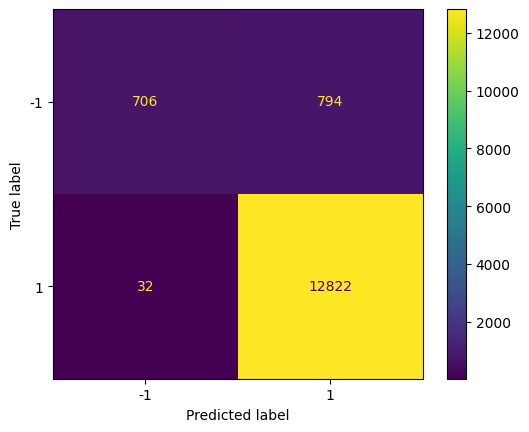

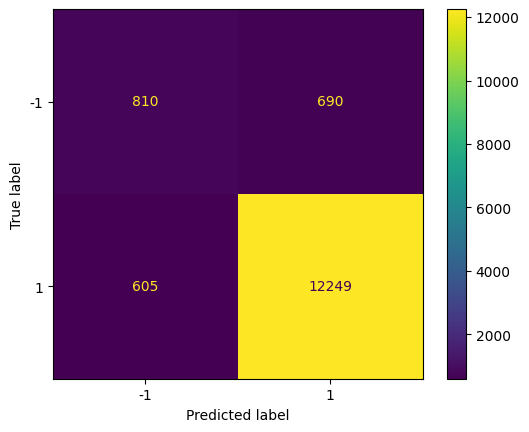

In [42]:
tmp = windows_post(y_hat)
for i in range(2, 4):
    tmp = windows_post(tmp, size=i)
print_score(y_test, tmp, "Best résult w/ postprocessing on test")
ConfusionMatrixDisplay(confusion_matrix(y_test, tmp), display_labels=pipeline.classes_).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat), display_labels=pipeline.classes_).plot()

On transforme surtout des -1 en 1. Il faudrait être plus sensible sur l'inverse

In [68]:
# C'est le résultat de la fonction de décision, si négatif on prédit -1, sinon 1 
confidence_score_test = pipeline.decision_function(X_test)
confidence_score_test = pd.Series(confidence_score_test)
df['confidence'] = confidence_score_test

100%|██████████| 14354/14354 [00:00<00:00, 16755.52it/s]


<AxesSubplot: >

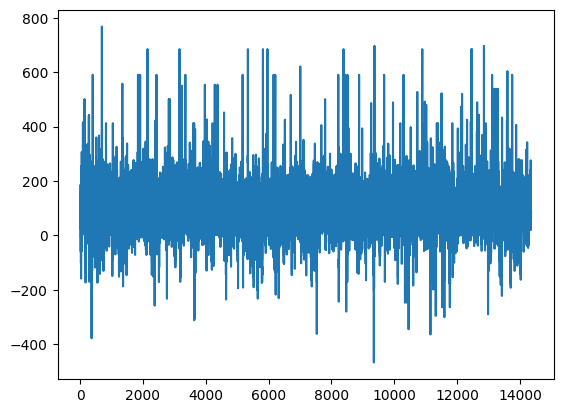

In [63]:
confidence_score_test.plot()

<AxesSubplot: >

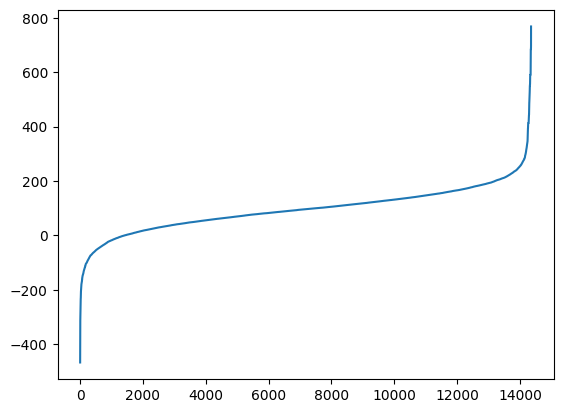

In [51]:
confidence_score_test.sort_values().reset_index(drop=True).plot()

In [52]:
confidence_score_test.describe()

count    14354.000000
mean        96.595018
std         85.321342
min       -466.968795
25%         49.217914
50%         96.390426
75%        143.058582
max        768.122555
dtype: float64

<AxesSubplot: >

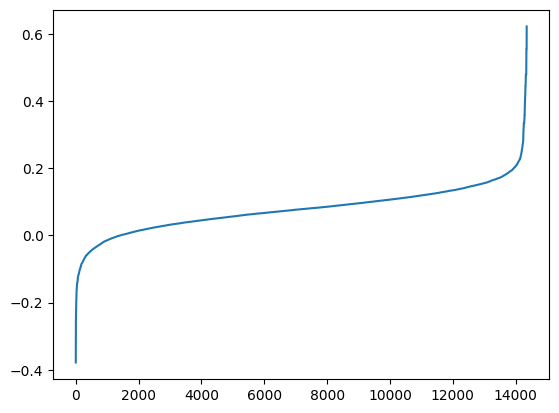

In [60]:
min_v = confidence_score_test.min()
mean_v = confidence_score_test.mean()
max_v = confidence_score_test.max()
conf_norm = pd.Series((confidence_score_test) / (max_v - min_v) )
conf_norm.sort_values().reset_index(drop=True).plot()

In [65]:
# C'est le résultat de la fonction de décision, si négatif on prédit -1, sinon 1 
confidence_score_train = pipeline.decision_function(X_train)
confidence_score_train = pd.Series(confidence_score_test)

100%|██████████| 43059/43059 [00:02<00:00, 15459.84it/s]


<AxesSubplot: >

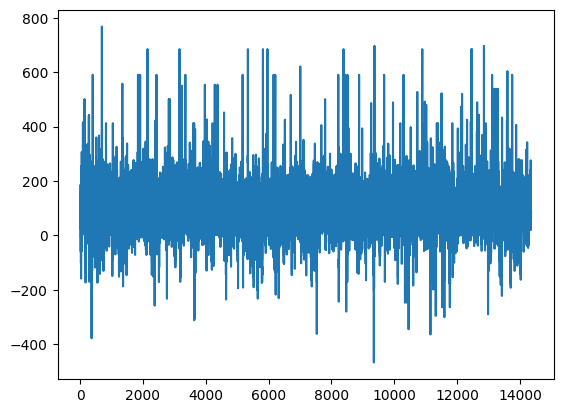

In [66]:
confidence_score_train.plot()

In [85]:
a = df['True Label'] == 1
b = df['True Label'] == -1
c = df['Prediction'] == 1
d = df['Prediction'] == -1

count    12249.000000
mean       116.199507
std         71.107823
min          0.097662
25%         69.218077
50%        107.295028
75%        151.618141
max        768.122555
Name: confidence, dtype: float64

Bonne prédiction sur 1

In [89]:
df.loc[a & c, "confidence"].describe()

count    12249.000000
mean       116.199507
std         71.107823
min          0.097662
25%         69.218077
50%        107.295028
75%        151.618141
max        768.122555
Name: confidence, dtype: float64

Bonne prédiction sur -1

In [86]:
df.loc[b & d, "confidence"].describe()

count    810.000000
mean     -71.055608
std       60.376824
min     -466.968795
25%      -97.643152
50%      -58.121207
75%      -27.182518
max       -0.160988
Name: confidence, dtype: float64

Mauvaise prédiction sur 1 (prédit -1 alors que 1)

In [87]:
df.loc[a & d, "confidence"].describe()

count    605.000000
mean     -27.454531
std       26.664842
min     -198.836639
25%      -40.479840
50%      -19.426344
75%       -7.775508
max       -0.007770
Name: confidence, dtype: float64

Mauvaise prédiction sur -1 (prédit 1 alors que -1)

In [88]:
df.loc[b & c, "confidence"].describe()

count    690.000000
mean      54.148062
std       40.859654
min        0.110392
25%       21.563715
50%       46.885975
75%       78.908114
max      254.589544
Name: confidence, dtype: float64